# Phoneme Recognition
**PAGE 148.** In this example we use splines to reduce flexibility rather than increase it; the application comes under the general heading of functional modeling. In the top panel of Figure 5.5 are displayed a sample of 15 log-periodograms for each of the two phonemes “aa” and “ao” measured at 256 frequencies. The goal is to use such data to classify a spoken phoneme. These two
phonemes were chosen because they are difficult to separate.


**DATA INFO.** The data were extracted from the TIMIT database (TIMIT Acoustic-Phonetic Continuous Speech Corpus, NTIS, US Dept of Commerce) which is a widely used resource for research in speech recognition. A dataset was formed by selecting five phonemes for
classification based on digitized speech from this database.  The phonemes are transcribed as follows: "sh" as in "she", "dcl" as in "dark", "iy" as the vowel in "she", "aa" as the vowel in "dark", and "ao" as the first vowel in "water".  From continuous speech of 50 male speakers, 4509 speech frames of 32 msec duration were selected, approximately 2 examples of each phoneme from each speaker.  Each speech frame is represented by 512 samples at a 16kHz sampling rate, and each frame represents one of the above five phonemes. The breakdown of the 4509 speech frames into phoneme frequencies is as follows:

|aa  |ao   |dcl |iy   |sh  |
|----|-----|----|-----|----|
|695 |1022 |757 |1163 |872 |

From each speech frame, we computed a log-periodogram, which is one of several widely used methods for casting speech data in a form suitable for speech recognition. Thus the data used in what follows consist of 4509 log-periodograms of length 256, with known class (phoneme) memberships. 

Variables:

|         |                                                       |
|---------|-------------------------------------------------------|
|x.1-x.256|log-periodogram of length 256                          |
|g        |phoneme                                                |
|speaker  |the speaker's identifier                               |

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline

# set common plots properties
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
# define commonly used colors
GRAY4 = '#646369'


def error_rate(y_true, y_pred):
    return 1 - accuracy_score(y_true, y_pred)

## Load and Prepare Data

In [2]:
df = pd.read_csv("../data/Phoneme Recognition.txt")
df.head()

,row.names,x.1,x.2,x.3,x.4,x.5,x.6,x.7,x.8,x.9,...,x.249,x.250,x.251,x.252,x.253,x.254,x.255,x.256,g,speaker
0,1,9.85770,9.20711,9.81689,9.01692,9.05675,8.92518,11.28308,11.52980,10.79713,...,12.68076,11.20767,13.69394,13.72055,12.16628,12.92489,12.51195,9.75527,sh,train.dr1.mcpm0.sa1
1,2,13.23079,14.19189,15.34428,18.11737,19.53875,18.32726,17.34169,17.16861,19.63557,...,8.45714,8.77266,9.59717,8.45336,7.57730,5.38504,9.43063,8.59328,iy,train.dr1.mcpm0.sa1
2,3,10.81889,9.07615,9.77940,12.20135,12.59005,10.53364,8.54693,9.46049,11.96755,...,5.00824,5.51019,5.95725,7.04992,7.02469,6.58416,6.27058,3.85042,dcl,train.dr1.mcpm0.sa1
3,4,10.53679,9.12147,10.84621,13.92331,13.52476,10.27831,8.97459,11.57109,12.35839,...,5.85688,5.40324,6.07126,5.30651,4.27412,3.63384,3.22823,4.63123,dcl,train.dr1.mcpm0.sa1
4,5,12.96705,13.69454,14.91182,18.22292,18.45390,17.25760,17.79614,17.76387,18.99632,...,8.00151,7.58624,6.65202,7.69109,6.93683,7.03600,7.01278,8.52197,aa,train.dr1.mcpm0.sa1


In [3]:
# PAGE 148. The goal is to use such data to classify a spoken phoneme. These
#           two phonemes were chosen because they are difficult to separate.
df = df[(df.g == 'aa') | (df.g == 'ao')]
df.g = pd.get_dummies(df.g)['ao']
target = 'g'
features = [f'x.{i+1}' for i in range(256)]
X, y = df[features].values, df[target].values
# data is split in a stratified fashion
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, train_size=1000, random_state=279, stratify=y)

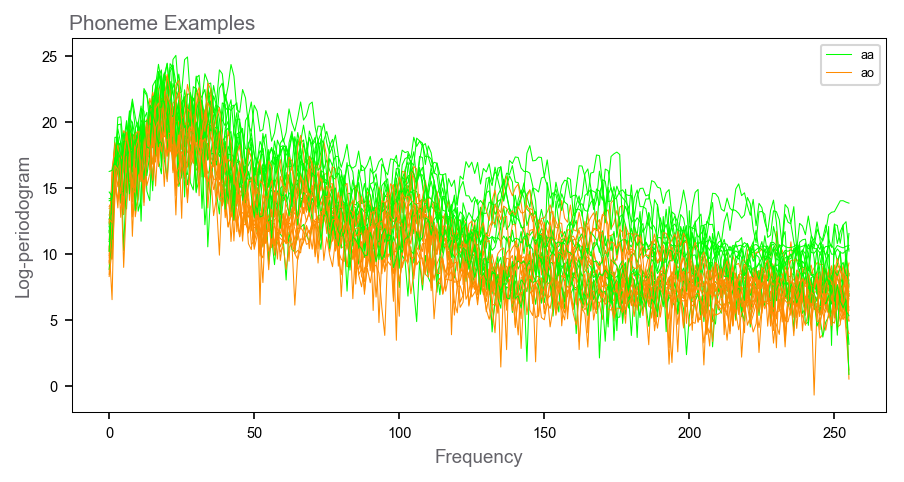

In [4]:
# PAGE 148. In the top panel of Figure 5.5 are displayed a sample of 15
#           log-periodograms for each of the two phonemes “aa” and “ao”
#           measured at 256 frequencies.
aa_first_15 = X[y == 0][:15]
ao_first_15 = X[y == 1][:15]

fig, ax = plt.subplots(figsize=(7, 3.3), dpi=150)
aa_label, ao_label = {'label': 'aa'}, {'label': 'ao'}
x_vals = range(256)
for i in range(15):
    ax.plot(x_vals, aa_first_15[i], linewidth=0.5, color='#00FF00', **aa_label)
    ax.plot(x_vals, ao_first_15[i], linewidth=0.5, color='#FF8C00', **ao_label)
    aa_label, ao_label = {}, {}
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)
ax.set_xlabel('Frequency', color=GRAY4, fontsize=9)
ax.set_ylabel('Log-periodogram', color=GRAY4, fontsize=9)
ax.legend(loc='upper right', prop={'size': 6})
_ = ax.text(-14, 27, 'Phoneme Examples', color=GRAY4, fontsize=10)

## Raw Logistic Regression

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [6]:
# LogisticRegression is regularized version, we put high value to C to minimize
# regularization
lr = LogisticRegression(
    solver='lbfgs', max_iter=100000, C=1e43, tol=1e-100
).fit(X_train, y_train)
lr_coef = np.squeeze(lr.coef_)
lr_train_error = error_rate(y_train, lr.predict(X_train))
lr_test_error = error_rate(y_test, lr.predict(X_test))
print(f'Training error: {lr_train_error:.3f}')
print(f'    Test error: {lr_test_error:.3f}')

Training error: 0.080
    Test error: 0.255


## Restricted Logistic Regression
**PAGE 150.** The smooth red curve was obtained through a very simple use of natural cubic splines. We can represent the coefficient function as an expansion of splines $\beta(f)=\sum_{m=1}^{M} h_{m}(f) \theta_{m}$. In practice this means that $\beta=\mathbf{H} \theta$ where, $\mathbf{H}$ is a $p × M$ basis matrix of natural cubic splines, defined on the set of
frequencies. Here we used $M = 12$ basis functions, with knots uniformly placed over the integers $1, 2,... , 256$ representing the frequencies. Since $x^{T} \beta=x^{T} \mathbf{H} \theta$, we can simply replace the input features $x$ by their *filtered*
versions $x^{*}=\mathbf{H}^{T} x$, and fit $\theta$ by linear logistic regression on the $x^{*}$. The red curve is thus $\hat{\beta}(f)=h(f)^{T} \hat{\theta}$.


**NOTE.** I did not find a Python library for natural cubic spline basis expansion and implemented it myself. The class has fit/transform methods and so can be used in pipelines. The formula for the expansion is given on the page 145 (5.4).

$N_{1}(X)=1, N_{2}(X)=X, N_{k+2}(X)=d_{k}(X)-d_{K-1}(X)$,

where $d_{k}(X)=\frac{(X-\xi_{k})_{+}^{3}-(X-\xi_{K})_{+}^{3}}{\xi_{K}-\xi_{k}}$

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List

In [8]:
class NaturalCubicSplineFeatures(BaseEstimator, TransformerMixin):
    """Generate natural cubic spline and interaction features.
    Parameters
    ----------
    knots :
        Is a list that contains knots list for each feature.
    add_interactions :
        If false, only natural cubic spline features are produced, otherwise
        expanded features interactions are included.
    target_dofs :
        Is a number of degrees of freedom for each feature. If is set, df+1
        knots for features would be automatically calculated at uniform
        quantiles including min and max value of a feature.
    Attributes
    ----------
    dofs_:
        The degrees of freedom for each feature.
    positions_:
        For each feature the index of the first and the last indices of its
        components."""
    def __init__(self, knots: List[List[float]]=None, target_dofs: int=None,
                 add_interactions: bool = False):
        self.knots = knots
        self.add_interactions = add_interactions
        self.target_dofs = target_dofs

    def fit(self, X: np.ndarray,
            y: np.array=None) -> 'NaturalCubicSplineFeatures':
        """Fit NaturalCubicSplineFeatures model according to the given training
           data and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        if self.target_dofs is not None:
            quantiles = np.linspace(0, 1, self.target_dofs + 1)
            self.knots = []
            for i in range(X.shape[1]):
                self.knots.append(np.unique(np.quantile(X[:, i], quantiles)))
        # calculate the number of parameters in each component term
        self.dofs_ = np.array([len(k)-1 for k in self.knots])
        # for each feature calculate the first and the last index of expanded
        # basis
        dofs_cumsum = [0] + list(np.cumsum(self.dofs_))
        self.positions_ = [(dofs_cumsum[i-1], dofs_cumsum[i]-1)
                           for i in range(1, len(dofs_cumsum))]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Transform data to natural cubic spline basis expansion
        Parameters
        ----------
        X :
            The data to transform, row by row
        Returns
        -------
        X_new : np.ndarray, shape [n_samples, NN]
            The matrix of features, where NN is the number of natural cubic
            spline features generated from the inputs based on knots.
        """
        features_basis_splines = []
        for i in range(X.shape[1]):
            features_basis_splines.append(
                self.__expand_natural_cubic(X[:, i:i+1], self.knots[i]))
        if self.add_interactions:
            self.__add_interaction_features(features_basis_splines)
        return np.hstack(features_basis_splines)

    @staticmethod
    def __dk(X: np.ndarray, knot: float, knot_last: float) -> np.ndarray:
        return (X - knot).clip(0) ** 3 / (knot_last - knot)

    @staticmethod
    def __expand_natural_cubic(X: np.ndarray, knots: np.array) -> np.ndarray:
        basis_splines = [X]
        dk_last = NaturalCubicSplineFeatures.__dk(X, knots[-2], knots[-1])
        for knot in knots[:-2]:
            dk = NaturalCubicSplineFeatures.__dk(X, knot, knots[-1])
            basis_splines.append(dk - dk_last)
        return np.hstack(basis_splines)

    @staticmethod
    def __add_interaction_features(features_basis_splines):
        features_indices = [list(range(expansion.shape[1]))
                            for expansion in features_basis_splines]
        for combination in itertools.product(*features_indices):
            product = features_basis_splines[0][:, combination[0]].copy()
            for i in range(1, len(combination)):
                product *= features_basis_splines[i][:, combination[i]]
            features_basis_splines.append(np.atleast_2d(product).T)

In [9]:
H = NaturalCubicSplineFeatures(
    target_dofs=12
).fit_transform(np.linspace(1, 256, 256).reshape((256, 1)))
lr = LogisticRegression(
    solver='liblinear', max_iter=10000000, C=1e42, tol=1e-100)
smoothed_lr = Pipeline(
    [('filter', FunctionTransformer(lambda X: (H.T @ X.T).T, validate=True)),
     ('logistic', lr)]
).fit(X_train, y_train)
smoothed_lr_train_error = error_rate(y_train, smoothed_lr.predict(X_train))
smoothed_lr_test_error = error_rate(y_test, smoothed_lr.predict(X_test))
lr_coef_filtered = H @ np.squeeze(lr.coef_)
print(f'Training error: {smoothed_lr_train_error:.3f}')
print(f'    Test error: {smoothed_lr_test_error:.3f}')

Training error: 0.174
    Test error: 0.170


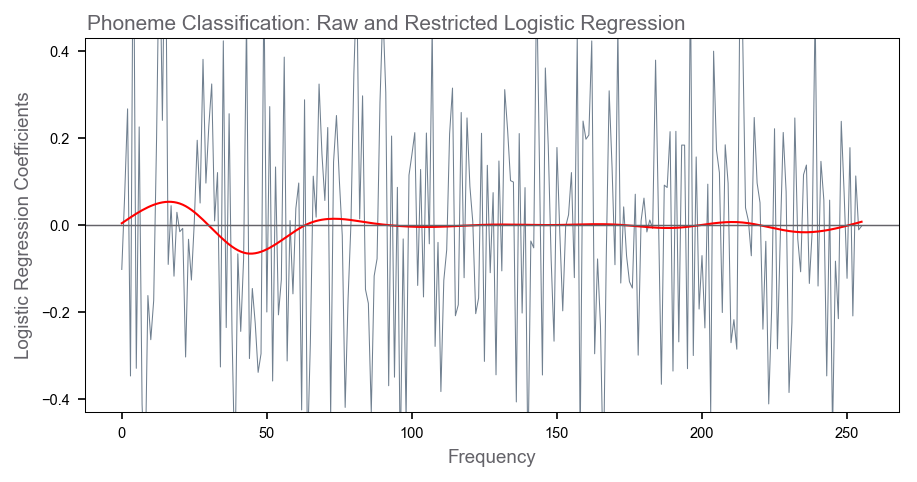

In [10]:
# PAGE 148. The gray lines in the lower panel of Figure 5.5 show the
#           coefficients of a linear logistic regression model fit by maximum
#           likelihood to a training sample of 1000 drawn from the total of 695
#           “aa”s and 1022 “ao”s. The coefficients are also plotted as a
#           function of frequency, and in fact we can think of the model in
#           terms of its continuous counterpart (5.7)
# PAGE 149. The coefficients are restricted to be smooth in the red curve, and
#           are  unrestricted in the jagged gray curve.
fig, ax = plt.subplots(figsize=(7, 3.3), dpi=150)
ax.plot(range(256), lr_coef, linewidth=0.5, color='#708090')
ax.plot(range(256), lr_coef_filtered, linewidth=1, color='red')
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(7)
ax.set_xlabel('Frequency', color=GRAY4, fontsize=9)
ax.set_ylabel('Logistic Regression Coefficients', color=GRAY4, fontsize=9)
ax.set_ylim(-0.43, 0.43)
ax.axhline(y=0, c=GRAY4, linewidth=0.7)
_ = ax.text(-12, 0.45,
            'Phoneme Classification: Raw and Restricted Logistic Regression',
            color=GRAY4, fontsize=10)

In [11]:
# PAGE 150. Applications such as this permit a natural regularization. We force
#           the coefficients to vary smoothly as a function of frequency. The
#           red curve in the lower panel of Figure 5.5 shows such a smooth
#           coefficient curve fit to these data. We see that the lower
#           frequencies offer the most discriminatory power. Not only does the
#           smoothing allow easier interpretation of the contrast, it also
#           produces a more accurate classifier:
print('                 Raw    Regularized')
print('-----------------------------------')
print(f'Training error  {lr_train_error:.3f} {smoothed_lr_train_error:>10.3f}')
print(f'    Test error  {lr_test_error:.3f} {smoothed_lr_test_error:>10.3f}')

                 Raw    Regularized
-----------------------------------
Training error  0.080      0.174
    Test error  0.255      0.170
